# Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from datetime import datetime, date
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *

2024-10-03 17:20:47.171062: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-03 17:20:47.175182: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-03 17:20:47.189947: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-03 17:20:47.214524: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-03 17:20:47.221789: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-03 17:20:48.560143: W tensorflow/compiler/tf2tensorrt/utils/p

# Input data - dropping date and bitcoin opening, high and low prices

In [2]:
data = pd.read_csv('/home/hoangbaoan1901/Development/predictive-analysis/Homeworks/week-3-btl/datasets/jrfm-2156907-cleaned.csv')

In [3]:
data = data.drop(columns=['Date', 'BTC_Open', 'BTC_High', 'BTC_Low'])


In [4]:
data.head()

,BTC_Close,BTC_Volume,Active Addr Cnt,Xfer Cnt,Mean Tx Size (native units),Total Fees (USD),Mean Hash Rate,Difficulty,Mean Block Size (in bytes),Sum Block Weight,...,RUB,Tweets,Google,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,279.584991,42484800.0,283150,497302,2.057514,7235.134845,356031.3023,5.227830e+10,506395.1825,277504560,...,64.480003,47467,90.000000,0,0,0,0,1,0,0
1,260.997009,58533000.0,266587,284532,3.675623,5806.842316,420413.4050,5.269984e+10,344357.2919,221766096,...,64.480003,29031,91.578947,0,0,0,0,0,1,0
2,265.083008,23789600.0,262571,276720,4.201519,4952.554125,372000.7193,5.269984e+10,362518.6127,205910572,...,64.480003,27132,91.578947,0,0,0,0,0,0,1
3,264.470001,20979400.0,292834,304538,3.463212,7563.840456,437493.8037,5.269984e+10,448765.0778,299775072,...,64.480003,27744,96.315789,1,0,0,0,0,0,0
4,270.385986,25433900.0,271613,280398,3.785274,7128.842169,424395.1868,5.269984e+10,414812.5617,268798540,...,62.889999,26653,104.210526,0,1,0,0,0,0,0


In [5]:
data.shape

(2430, 44)

In [6]:
data.isna().sum()

BTC_Close                      0
BTC_Volume                     0
Active Addr Cnt                0
Xfer Cnt                       0
Mean Tx Size (native units)    0
Total Fees (USD)               0
Mean Hash Rate                 0
Difficulty                     0
Mean Block Size (in bytes)     0
Sum Block Weight               0
LTC                            0
XRP                            0
DASH                           0
DOGE                           0
ETH                            0
Gold                           0
Silver                         0
Copper                         0
Oil                            0
Treasury Yield 10 Years        0
S&P500                         0
DJI                            0
CBOE                           0
NASDAQ                         0
JP225                          0
CSI300                         0
DXY                            0
EUR                            0
GBP                            0
JPY                            0
CAD       

# Split data into train and test set

In [7]:
# Define train size, test size = 1 - train size
train_size = int(len(data) * 0.8)
train_set = data.iloc[:train_size]
test_set = data.iloc[train_size:]

In [8]:
# Define the target variable
target = 'BTC_Close'

# Create the feature sets
X_train = train_set.drop(columns=[target])
X_test = test_set.drop(columns=[target])

# Create the target sets
Y_train = train_set[target]
Y_test = test_set[target]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

ts = 1 # Define the time step
# Create sequences with a time step of 10
def create_sequences(data, target, time_step=ts):
	X, y = [], []
	for i in range(len(data) - time_step):
		X.append(data[i:(i + time_step)])
		y.append(target[i + time_step])
	return np.array(X), np.array(y)

X_train, Y_train = create_sequences(X_train.values, Y_train.values)
X_test, Y_test = create_sequences(X_test.values, Y_test.values)

print("X_train shape after sequencing:", X_train.shape)
print("X_test shape after sequencing:", X_test.shape)
print("Y_train shape after sequencing:", Y_train.shape)
print("Y_test shape after sequencing:", Y_test.shape)

X_train shape: (1944, 43)
X_test shape: (486, 43)
Y_train shape: (1944,)
Y_test shape: (486,)
X_train shape after sequencing: (1943, 1, 43)
X_test shape after sequencing: (485, 1, 43)
Y_train shape after sequencing: (1943,)
Y_test shape after sequencing: (485,)


# Normalize data with MinMaxScaler

In [9]:
# Normalize the datasets using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both train and test data
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Update the variables used for training
X_train = X_train_scaled
X_test = X_test_scaled

print(X_train) 

[[[4.01545319e-04 2.94214860e-02 1.36994944e-01 ... 1.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[6.17991520e-04 1.34609177e-02 1.80960758e-02 ... 0.00000000e+00
   1.00000000e+00 0.00000000e+00]]

 [[1.49398348e-04 9.59098815e-03 1.37306203e-02 ... 0.00000000e+00
   0.00000000e+00 1.00000000e+00]]

 ...

 [[4.39527163e-01 7.57475102e-01 2.88508436e-01 ... 0.00000000e+00
   1.00000000e+00 0.00000000e+00]]

 [[4.19740237e-01 6.00430742e-01 2.45779836e-01 ... 0.00000000e+00
   0.00000000e+00 1.00000000e+00]]

 [[6.43554833e-01 6.27285123e-01 2.74355352e-01 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]]


# Model initialization & compilation

In [10]:
model = tf.keras.Sequential([
	tf.keras.layers.LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
	tf.keras.layers.Dropout(0.2),
	tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
	tf.keras.layers.Dropout(0.3),
	tf.keras.layers.LSTM(256, activation='relu', return_sequences=True),
	tf.keras.layers.Dropout(0.4),
	tf.keras.layers.LSTM(256, activation='relu', return_sequences=False),
	tf.keras.layers.Dropout(0.5),
	tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

I0000 00:00:1727950850.983021   83100 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-03 17:20:51.008847: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/hoangbaoan1901/Development/predictive-analysis/Homeworks/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model 

# Fit train set with label using LSTM model, predict & visualization

In [11]:
# Fit the model
history = model.fit(X_train, Y_train, epochs=30)

Epoch 1/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 46970904.0000 - mae: 5287.1606
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7611638.5000 - mae: 2282.4873
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3153469.2500 - mae: 1399.4829
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2498406.7500 - mae: 1139.2407
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2642077.0000 - mae: 1053.5153
Epoch 6/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2597644.0000 - mae: 1057.5436
Epoch 7/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2248252.5000 - mae: 974.2104
Epoch 8/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2312304.7500 - mae: 961.0142
Epoch 9/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2152772.2500 - mae: 951.1855
Epoch 10/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2162699.2500 - mae: 950.6596
Epoch 11/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2325081.2500 - mae: 967.4357
Epoch 12/30
61/61 ━━━━━

In [12]:
# Use the model to make predictions on the test set
predictions = model.predict(X_test)

# Print the predictions
print(predictions)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
[[15267.488]
 [15737.039]
 [15228.951]
 [15275.731]
 [14961.512]
 [15344.539]
 [15114.953]
 [14741.287]
 [14254.936]
 [14329.776]
 [14447.148]
 [14862.398]
 [14691.841]
 [15022.551]
 [17575.23 ]
 [18657.646]
 [17492.791]
 [17287.396]
 [17045.648]
 [16946.1  ]
 [16378.996]
 [16261.833]
 [15686.832]
 [16313.043]
 [17287.318]
 [18723.74 ]
 [18002.174]
 [17734.043]
 [18693.38 ]
 [18227.69 ]
 [17061.385]
 [21341.26 ]
 [22961.338]
 [21151.197]
 [20683.22 ]
 [22131.873]
 [24016.494]
 [23865.17 ]
 [22724.146]
 [23009.182]
 [23961.4  ]
 [21838.984]
 [21611.338]
 [22469.295]
 [21129.553]
 [20467.91 ]
 [19799.021]
 [20518.686]
 [21123.088]
 [20782.783]
 [20531.096]
 [21154.174]
 [20063.107]
 [20031.729]
 [20675.037]
 [20421.705]
 [19144.299]
 [21608.959]
 [26266.377]
 [21608.912]
 [20910.06 ]
 [21624.348]
 [22550.986]
 [23380.86 ]
 [24034.064]
 [24563.143]
 [25431.576]
 [25194.486]
 [31078.818]
 [30097.338]
 [28136.236]
 [27503.172]
 [28524.436]
 [28131.604

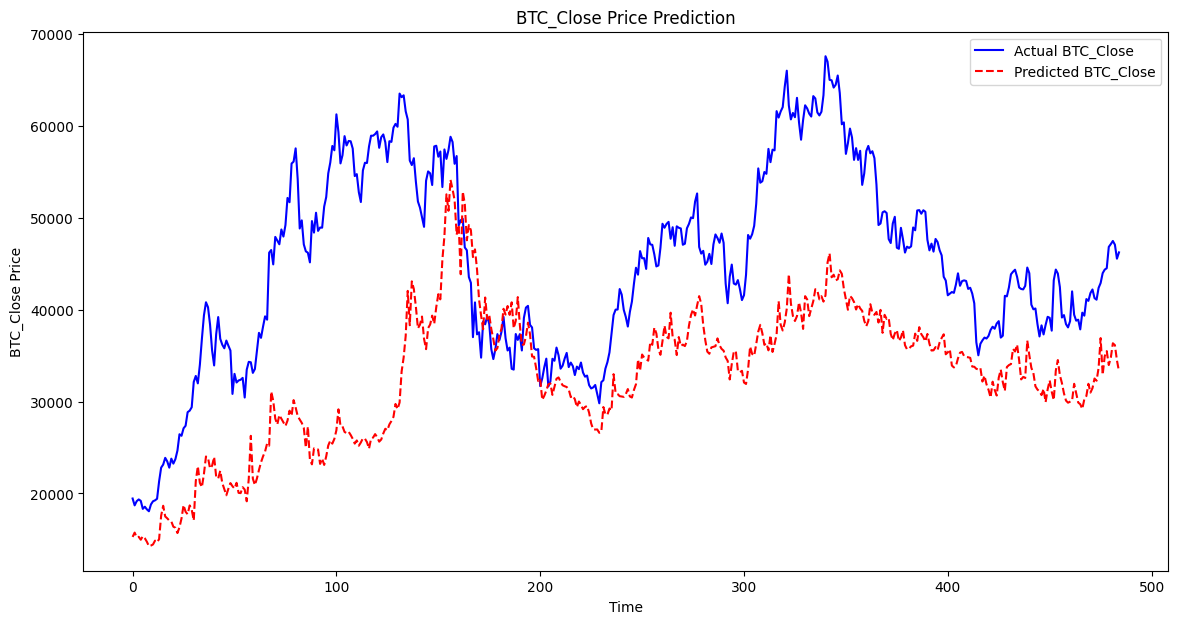

In [13]:
# Plot the predictions against the actual values
plt.figure(figsize=(14, 7))
plt.plot(Y_test, color='blue', label='Actual BTC_Close')
plt.plot(predictions, color='red', label='Predicted BTC_Close', linestyle='dashed')
plt.title('BTC_Close Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC_Close Price')
plt.legend()
plt.show()